<a href="https://colab.research.google.com/github/zghafoori/Deep-Clustering/blob/master/Deep_clustering_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Clustering - Part 1: Quality of the clusters initialisation

Clustering refers to dividing data points into groups such that members of the same group are more similar to each other compared to those in other groups. Traditional methods of clustering typically use similarity measures to compare data points and assign them to clusters.


Deep clustering refers to using deep neural networks to map a high dimentional data to a new lower-dimentinal *hidden space*. The aim is to improve the accuracy of clustering by increasing the inter-cluster dissimilarity as well as instra-cluster similarity in the hidden space. In addition, the neural network is used to generate abstract and useful features such that the effect of the curse of dimentionality on the similarity measure, which is used for clustering, is minimised. The final clustering is performed in the hidden space and the clustering loss in backpropagated through the network to tune the neural network weights and consequently the data representation in the hidden space.

The quality of final clustering in deep clustering highly depends on the initialisation of the clusters in the hidden space. The typcal way of performing this step is to train an autoencoder and use the encoder part of it to initialise the data mapping to the hidden space. This is shown in Figure 1.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1xM4nBJd9ciyhbItW5V5b5BQVDRAe_U9a' width="600"/>
<figcaption>Figure 1. General steps in deep clustering. (Step 1) Training an autoencoder to initialise the data embedding in the hidden space. (Step 2) Fine tuning the network weights and the data embedding using a clustering based loss function. The aim is to increase the inter-cluster dissimilarity and intra-cluster similarities.</figcaption></center>
</figure>

In this serries, the quality of the clusters initialisation is investigated as it affects the final quality of clusters in deep clustering. MNIST dataset is used to show how the choice of the autoencoder will affect the quality of initial clustering in the hidden space. The following types of autoencoders with symetric architectures are used.

1. Simple autoencoder
2. Convolutional autoencoder
3. Variational convolutional autoencoder


# Data Preparation

Data preparation is one of the most important steps in data modelling. In this section, the MNIST data is downloaded and prepared for analyses. Preprocessing steps are applied on the images first to increase the performance of the applied methods.

Now, let's load the python libraries and modules that are used in this document.

In [0]:
# Importing the required libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.datasets import mnist

from keras.layers import Input, InputLayer, Activation
from keras.layers import Dense, Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Flatten, Reshape, Lambda
from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy
from keras import backend as K

Using TensorFlow backend.


Deskewing is the process of straightening an image that is slanting too far in one direction or is misaligned. The following functions are used for performing this process. We use this preprocessing step to align the digit images in the MNIST dataset.

In [0]:
# The data preprocessing step for the image data using deskewing technique
from scipy.ndimage import interpolation
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

The MNIST dataset is first downloaded and normalised in the range $[0, 1]$ by devision to 255.

In [0]:
# Extracting the MNIST train and test sets 
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

# Rescaling the data in the range [0,1]
xTrain = xTrain/255.
xTest = xTest/255.

11493376/11490434 [==============================] - 11s 1us/step


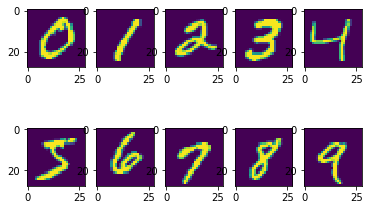

In [0]:
# Display a sample image per digit before the data preprocessing step
for i in np.unique(yTrain,return_index=True)[1]:
  ax = plt.subplot(2,5,yTrain[i]+1)
  ax.imshow(xTrain[i])

This deskewing method is applied on the images and the result is again normalised in the range $[0, 1]$ by means of min-max scaling method. This step can be skipped to see how the results will change without the application of deskewing.

In [0]:
# Deskewing MNIST train and test set
for i in range(len(xTrain)):
  xTrain[i] = deskew(xTrain[i])
for i in range(len(xTest)):
  xTest[i] = deskew(xTest[i])

# Reshaping data instances to be in the shape 1-by-(28*28) 
imgSize = xTrain.shape[1:]
xTrain = xTrain.reshape([-1, np.prod(imgSize)]).astype(np.float32)
xTest = xTest.reshape([-1, np.prod(imgSize)]).astype(np.float32)

# Normalising the data in the range [0,1] using the MinMax scaler method:
# per feature vector v: v = (v-min(v))/(max(v)-min(v))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

We can see that in the sample images, digits $0$, $3$ and $8$ are evidently aligned. 

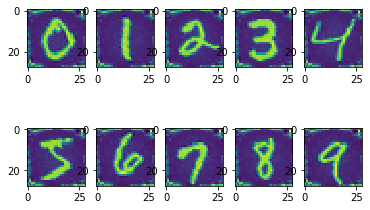

In [0]:
# Display a sample image per digit after the data preprocessing step
for i in np.unique(yTrain,return_index=True)[1]:
  ax = plt.subplot(2,5,yTrain[i]+1)
  ax.imshow(xTrain[i].reshape(28,28))

# Symetric Autoencoder

The idea is to use an autoencoder with a bottleneck-like structures that includes an encoder followed by a decoder. The aim is to project the data to a much lower number of dimentions then reconstruct the input from the hidden lower-dimentional data representation. As a by-product of this process, a new feature space is created in the last layer of the encoder, which extracts usfule and abstract features from the data. 

In this section, the option of using a simple symetric autoencoder for this goal is investigated. The structure of the autoencoder is chosen based on the typical network structure used in the related literature.

In [0]:
# Reset the session to delete old models if required
# Skip this step if it is not required
K.clear_session()

In [0]:
# Setting parameters
# Network structure for the encoder
# By experimemt the choice of [xTrain.shape[1],1000,10] also works well
units = [xTrain.shape[1],500,500,2000,10] 
optimizer = 'adam'
loss = 'mse'
activation = 'relu'
batch_size = 256
n_epochs = 200
k = 10 # number of clusters

Building the encoder and displaying its properties.

In [0]:
# Encoder
encoder = Sequential(name='encoder')
encoder.add(Dense(units[1], input_dim=units[0], activation=activation))
for i in range(2,len(units)-1):
  encoder.add(Dense(units[i], activation=activation))
encoder.add(Dense(units[-1]))
encoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20010     
Total params: 1,665,010
Trainable params: 1,665,010
Non-trainable params: 0
_________________________________________________________________


Building the decoder and displaying its properties.

In [0]:
# Decoder
decoder = Sequential(name='decoder')
decoder.add(Dense(units[-2], input_dim=units[-1], activation=activation))
for i in range(-3,-len(units),-1):
  decoder.add(Dense(units[i], activation=activation))
decoder.add(Dense(units[0]))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2000)              22000     
_________________________________________________________________
dense_6 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_7 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_8 (Dense)              (None, 784)               392784    
Total params: 1,665,784
Trainable params: 1,665,784
Non-trainable params: 0
_________________________________________________________________


Building the autoencoder and displaying its properties.

In [0]:
#Simple autoencoder
inputs = Input(shape=(xTrain.shape[1],))
encoded = encoder(inputs)
decoded = decoder(encoded)
ae = Model(inputs,decoded)
ae.compile(optimizer=optimizer, loss=loss)
ae.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Sequential)         (None, 10)                1665010   
_________________________________________________________________
decoder (Sequential)         (None, 784)               1665784   
Total params: 3,330,794
Trainable params: 3,330,794
Non-trainable params: 0
_________________________________________________________________


By calling the fit method, the training is begun and the network weights of the encoder and decoder are updated. The Mean-Squered_error of the reconstructions is used as the loss fuction and it is optimised using Adam optimizer. A $1$ to $4$ ration is used to divide the data to the validation and training sets. The training progress and history of the training loss are depicted. 




Train on 11999 samples, validate on 48001 samples
Epoch 1/200





11999/11999 [==============================] - 10s 852us/step - loss: 0.0421 - val_loss: 0.0295
Epoch 2/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0292 - val_loss: 0.0290
Epoch 3/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0252 - val_loss: 0.0215
Epoch 4/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0196 - val_loss: 0.0177
Epoch 5/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0159 - val_loss: 0.0150
Epoch 6/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0138 - val_loss: 0.0134
Epoch 7/200
11999/11999 [==============================] - 1s 61us/step - loss: 0.0125 - val_loss: 0.0126
Epoch 8/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0117 - val_loss: 0.0118
Epoch 9/200
11999/11999 [==============================] - 1s 60us/step - loss: 0.0108 - val

Text(0, 0.5, 'Training Loss')

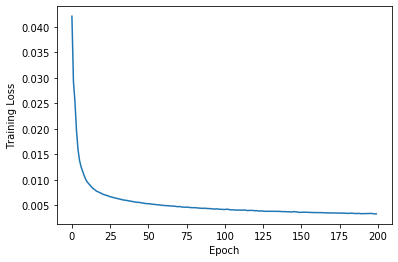

In [0]:
results = ae.fit(x=xTrain,y=xTrain,batch_size=batch_size,
       epochs=n_epochs,verbose=1,validation_split=0.8)
plt.plot(results.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

The models can be saved in the desired file directories. For this aim,
 the path variable should be modified accordingly.

In [0]:
# Saving the models
path = "sample_data" # for me! change it if needed for you!
decoder.save(path+"/symSimple_dec.h5")
encoder.save(path+"/symSimple_enc.h5")
ae.save(path+"/symSimple_ae.h5")

Now let's find the clusters in the hidden space by applying K-means algorithm as it's typically used in deep clustering methods for initialisation of the clusters. Also, the evaluation of the quality of this initial clustering step on the output of the encoder can be done by means of the ground-truth labels. 

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
# Map the data to the feature (i.e., hidden) space
mapped_data = encoder.predict(xTrain)
# K-means with 10 clusters
km = KMeans(n_clusters=k) # k is 10 for MNIST
km.fit(mapped_data)
# Map the test data to the feature space
mapped_data = encoder.predict(xTest)
# idx stores the cluster membership of the test data
idx = km.predict(mapped_data)

In [0]:
# Matching the labels of the identified clusters
from scipy.stats import mode
labels = np.zeros_like(idx)
for i in range(k):
  mask = (idx == i)
  labels[mask] = mode(yTest[mask])[0]
acc = accuracy_score(yTest, labels)
print("The accuracy of clustering is ", acc)  

The accuracy of clustering is  0.8496


Different tools, such as PCA, can be used to visualise the clusters. Here, the aim is to preserve the structure of the clusters, thus tSNE can be used. We choose a subset of the data as performing this calculations on the whole dataset is expensive.

In [0]:
from sklearn.manifold import TSNE
# Choosing a sample of the data at random
ix = np.random.permutation(range(len(yTest)))
ix = ix[:1000]
# Creating a dataset that includes the samples and the cluster centers 
data = np.append(km.cluster_centers_,mapped_data[ix],axis=0)
# Applying tSNE to project the data to a 2D data representation
tsne = TSNE(n_components=2)
z = tsne.fit_transform(data)

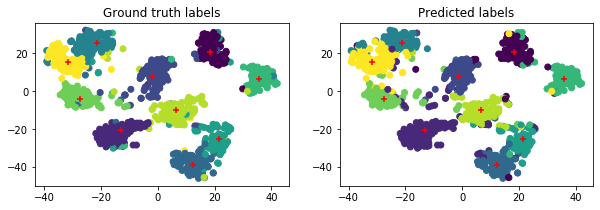

In [0]:
# Plot the ground truth data vs the predicted labels
cn = len(km.cluster_centers_)
f = plt.figure(figsize=(10,3))
ax1 = f.add_subplot(121)
ax1.title.set_text("Ground truth labels")
ax1.scatter(z[cn:,0],z[cn:,1],c=yTest[ix])
ax1.scatter(z[:cn,0],z[:cn,1],c='r',marker='+')
# Predictions
ax2 = f.add_subplot(122)
ax2.title.set_text("Predicted labels")
ax2.scatter(z[cn:,0],z[cn:,1],c=labels[ix])
ax2.scatter(z[:cn,0],z[:cn,1],c='r',marker='+')


In [0]:
# Save the embedings of the test set
path = "sample_data"
np.savetxt("/mapped_data.csv",mapped_data,fmt="%10.5f")
np.savetxt("/mapped_data_labels.csv",yTest,fmt="%s")

# Convolutional Autoencoder

Convolution is a specialised kind of a linear operation. The convolutional process involves progressively focusing on overlapping tile shape regions and sequentially shifting them. This process is shown in Figure 2. In practice, the tiles are defined using kernels. A kernel is a marix with a size smaller than the size of the input image, and is convolved with the input volume to obtain what is called the *activation maps*. Activation maps indicate regions where features specific to the kernel have been detected in the input.

<figure>
<center>
<img src='http://deeplearning.net/software/theano/_images/no_padding_no_strides.gif' width="250"/>
<figcaption>Figure 2. An example of the convolution process.</figcaption></center>
</figure>

A convolutional neural networks consist of at least one convolutional layer and it might also include the traditional fully connected layers. Convolutional neural networks are usually used to process image and video data. They are also widely used in natural language processing. In this section, a convolutional autoencoder that consists of convolutional and fully connected layers is trained to model the encoder and initialise the clusters in the feature space.

The MNIST dataset that was preprocessed so far should be reshaped to images of size 28-by-28. Also new parameters are introduced for the convolution operations inclusing the number of kernels and their sizes as well as if the original image should be padded or not.

In [0]:
# Reshape the data in image forma for the convolution layers
x_train = xTrain.reshape((-1,imgSize[0],imgSize[1],1))
y_train = yTrain
x_test = xTest.reshape((-1,imgSize[0],imgSize[1],1))
y_test = yTest

In [0]:
# Setting parameters
n_kernels = [32,64,128]
kernel_size = [5,5,3]
dense_units = [10]
padding = ['same','same','valid']
# Uncomment or change the following lines if the parameters should be reinitialised
#optimizer = 'adam'
#loss= 'mse'
#activation = 'relu'
#batch_size = 256
#n_epochs = 200
#k = 10 # number of clusters

The following code snippets build and summarise the structure of the convolutional autoencoder and its corresponding encoder for data embedding. This structure is chosen based on the related literature and can be changed to see how it affects the results.

In [0]:
# Building the encoder part of the convolutional autoencoder
cae = Sequential()
cae.add(InputLayer(input_shape=x_train.shape[1:]))
for i in range(len(n_kernels)):
  cae.add(Conv2D(n_kernels[i], kernel_size[i],
                   strides=2, padding=padding[i],
                   activation=activation, name='conv'+str(i+1)))
l_shape = cae.get_output_shape_at(-1)[1:]
cae.add(Flatten())
for i in range(len(dense_units)):
  actv = activation if i+1 < len(dense_units) else None
  name = 'dense'+str(i+1) if i+1 < len(dense_units) else 'dense'+str(i+1)+'-embedding'
  cae.add(Dense(units=dense_units[i], activation=actv, name=name))
conv_encoder = Model(inputs=cae.input, outputs=cae.get_layer(name).output)

In [0]:
conv_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense1-embedding (Dense)     (None, 10)                11530     
Total params: 137,482
Trainable params: 137,482
Non-trainable params: 0
_____________________________________________________

In [0]:
# Building the decoder part of the convolutional autoencoder
cae.add(Dense(units=np.prod(l_shape), 
              activation=activation, name='dense'+str(len(dense_units)+1)))
for i in range(-2,-(len(dense_units)+1),-1):
  cae.add(Dense(units=dense_units[i],
                activation=activation, name='dense'+str(len(dense_units)-i)))
cae.add(Reshape(l_shape))
for i in range(-2,-(len(n_kernels)+1),-1):
  cae.add(Conv2DTranspose(n_kernels[i], kernel_size[i+1],
                   strides=2, padding=padding[i+1],
                   activation=activation, name='deconv'+str(-i-1)))
cae.add(Conv2DTranspose(x_train.shape[-1], kernel_size[0],
                   strides=2, padding=padding[0], name='deconv'+str(len(n_kernels))))

In [0]:
cae.compile(optimizer=optimizer, loss=loss)
cae.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 14, 14, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense1-embedding (Dense)     (None, 10)                11530     
_________________________________________________________________
dense2 (Dense)               (None, 1152)              12672     
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 3, 128)        

By calling the fit method, the training is begun and the network weights of the encoder and decoder are updated. The Mean-Squered_error of the reconstructions is used as the loss fuction and it is optimised using Adam optimizer. A $1$ to $4$ ration is used to divide the data to the validation and training sets. The training progress and history of the training loss are depicted. 

Train on 11999 samples, validate on 48001 samples
Epoch 1/200
11999/11999 [==============================] - 6s 530us/step - loss: 0.0637 - val_loss: 0.0342
Epoch 2/200
11999/11999 [==============================] - 1s 99us/step - loss: 0.0307 - val_loss: 0.0294
Epoch 3/200
11999/11999 [==============================] - 1s 99us/step - loss: 0.0292 - val_loss: 0.0289
Epoch 4/200
11999/11999 [==============================] - 1s 100us/step - loss: 0.0258 - val_loss: 0.0221
Epoch 5/200
11999/11999 [==============================] - 1s 100us/step - loss: 0.0181 - val_loss: 0.0157
Epoch 6/200
11999/11999 [==============================] - 1s 99us/step - loss: 0.0138 - val_loss: 0.0128
Epoch 7/200
11999/11999 [==============================] - 1s 99us/step - loss: 0.0117 - val_loss: 0.0113
Epoch 8/200
11999/11999 [==============================] - 1s 99us/step - loss: 0.0104 - val_loss: 0.0104
Epoch 9/200
11999/11999 [==============================] - 1s 100us/step - loss: 0.0096 - val_loss:

Text(0, 0.5, 'Training Loss')

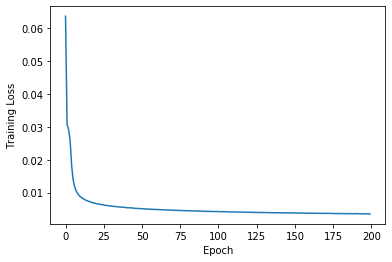

In [0]:
# Training the cae using the training data and the predefined parameters
results = cae.fit(x=x_train,y=x_train,batch_size=batch_size,
       epochs=n_epochs,verbose=1,validation_split=0.8)
plt.plot(results.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

The models can be saved in the desired file directories. For this aim,
 the path variable should be modified accordingly.

In [0]:
# Saving the models
path = "sample_data" # change this path to save models in a target directory!
conv_encoder.save(path+"/conv_enc.h5")
cae.save(path+"/conv_ae.h5")

Similar to what was done for the simple autoencoder scenario, the encoder is used to map the data to the feature space, perform the clustering and evaluate the quality of it using the ground truth. 

In [0]:
# Map data to the feature space
mapped_data = conv_encoder.predict(x_train)
# K-means with 10 clusters
km = KMeans(n_clusters=k) # k is 10 for MNIST
km.fit(mapped_data)
# Map the test data to the feature space
mapped_data = conv_encoder.predict(x_test)
# idx stores the cluster membership of the test data
idx = km.predict(mapped_data)

In [0]:
# Match the clustering membership to the predicted labels
labels = np.zeros_like(idx)
for i in range(k):
  mask = (idx == i)
  labels[mask] = mode(y_test[mask])[0]
acc = accuracy_score(y_test, labels)
print("The accuracy of clustering is ", acc)  

The accuracy of clustering is  0.8914


It can be observed that the accuracy is significantly increased when the convolutional autoencoder is used instead of the simple one. This is because the convolution operations make it possible to create more expressive features, which results in a better quality of the clustering. Note that the result will be different though if the initial preprocessing on the images is not performed.

To comapre the results visually, again tSNE is used embed the data in a 2D representation.

In [0]:
# Map the sample data using the convolutional encoder
data = np.append(km.cluster_centers_,mapped_data[ix],axis=0)
tsne = TSNE(n_components=2)
conv_z = tsne.fit_transform(data)

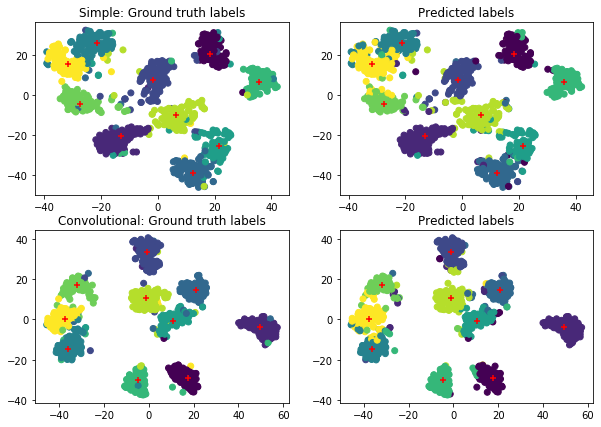

In [0]:
# Plot the ground truth data vs the predicted clusters
cn = len(km.cluster_centers_)
f = plt.figure(figsize=(10,7))

# Plotting old results for comparison
ax1 = f.add_subplot(221)
ax1.title.set_text("Simple: Ground truth labels")
ax1.scatter(z[cn:,0],z[cn:,1],c=y_test[ix])
ax1.scatter(z[:cn,0],z[:cn,1],c='r',marker='+')
# Predictions
ax2 = f.add_subplot(222)
ax2.title.set_text("Predicted labels")
ax2.scatter(z[cn:,0],z[cn:,1],c=labels[ix])
ax2.scatter(z[:cn,0],z[:cn,1],c='r',marker='+')

# Plotting new results
ax1 = f.add_subplot(223)
ax1.title.set_text("Convolutional: Ground truth labels")
ax1.scatter(conv_z[cn:,0],conv_z[cn:,1],c=y_test[ix])
ax1.scatter(conv_z[:cn,0],conv_z[:cn,1],c='r',marker='+')
# Predictions
ax2 = f.add_subplot(224)
ax2.title.set_text("Predicted labels")
ax2.scatter(conv_z[cn:,0],conv_z[cn:,1],c=labels[ix])
ax2.scatter(conv_z[:cn,0],conv_z[:cn,1],c='r',marker='+')


It can be observed that the data embedding generated using the convolutional neural network (two bottom figures) separates the clusters better compared to the simple autoencoder scenario (two top figures). The embedding is also less noisy and craetes more compact clusters.

This summary concludes the case study. One can also investigate the application of variational autoencoders as well as variational convolutional autoencoders to see how the initial embedding of the clusters will change.